<a href="https://colab.research.google.com/github/Lakshmanaraja/Teaching-Deep-Learning/blob/main/Image_Classifier_Advanced_ResNet_STEM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch  #Import necessary libraries
import torch.nn 

In [2]:
!pip install -Uqq fastbook #Install Fastbook for fast ai libraries


     |████████████████████████████████| 720 kB 5.2 MB/s 
     |████████████████████████████████| 189 kB 50.2 MB/s 
     |████████████████████████████████| 48 kB 4.9 MB/s 
     |████████████████████████████████| 1.2 MB 42.3 MB/s 
     |████████████████████████████████| 55 kB 4.0 MB/s 
     |████████████████████████████████| 561 kB 46.9 MB/s 
     |████████████████████████████████| 51 kB 317 kB/s 
     |████████████████████████████████| 130 kB 51.3 MB/s 


In [3]:
import fastbook
from fastbook import * #Importing fast ai libraries

In [4]:
#Function to return DataLoader from the URL with specified size
def get_data(url,presize,resize):
  path = untar_data(url)
  return DataBlock(blocks=(ImageBlock , CategoryBlock ), get_items=get_image_files, splitter = GrandparentSplitter(valid_name='val'), 
                   get_y = parent_label , item_tfms = Resize(presize), 
                   batch_tfms = [*aug_transforms(min_scale = 0.5 , size=resize), Normalize.from_stats(*imagenet_stats)],).dataloaders(path,bs=128)


In [5]:
#Initialising Imagenette Data Loader
dls = get_data(URLs.IMAGENETTE_160,160,128)

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1051: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:766.)
  ret = func(*args, **kwargs)


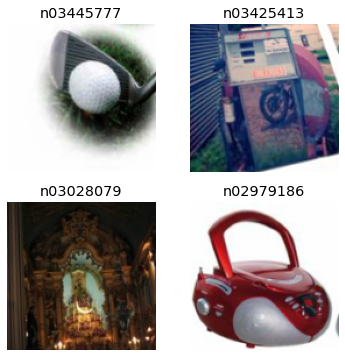

In [6]:
#Some sample of Dataset
dls.show_batch(max_n=4)

In [20]:
class ResNet(nn.Sequential):

  def __init__(self,n_out,layers,expansion = 1):

    stem = _resnet_stem(3,32,32,64)
    
    self.block_szs = [64,64,128,256,512]

    for i in range(1,5): self.block_szs *= expansion

    blocks = [self._make_layer(*o) for o in enumerate(layers) ]

    super().__init__(*stem , 
                    *blocks, 
                    nn.AdaptiveAvgPool2d(1), Flatten(), 
                    nn.Linear(self.block_szs[-1],n_out))    

  def _make_layer( self , idx, n_layers):
    
    stride = 1 if idx == 0 else 2
    
    ch_in,ch_out = self.block_szs[idx:idx+2]

    return nn.Sequential(*[
                          
                      ResBlock(ch_in if i==0 else ch_out, ch_out, stride if i == 0 else 1 )
                      for i in range(n_layers)
                         ])

In [14]:
#Resnet Stem

def _resnet_stem(*sizes):
  return [ ConvLayer(sizes[i],sizes[i+1],3,stride=2 if i==0 else 1 ) for i in range(len(sizes)-1)] + [nn.MaxPool2d(kernel_size=3,stride=2, padding=1 ,ceil_mode=False)]

In [15]:
_resnet_stem(3,32,32,64)

[ConvLayer(
   (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
   (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (2): ReLU()
 ), ConvLayer(
   (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
   (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (2): ReLU()
 ), ConvLayer(
   (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
   (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (2): ReLU()
 ), MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)]

In [9]:
#Resnet Block class with covolution and identity convolution along with pooling layer
class ResBlock(Module):
  def __init__(self,ni,nf, stride=1):
    
    self.convs = _conv_block(ni,nf,stride) #Normal Convolution layer
    self.idconv = noop if ni==nf else ConvLayer(ni,nf,1, act_cls=None) #Identity Mapping for ResNet used to match the dimensions of I/P and O/P
    self.pool = noop if stride==1 else nn.AvgPool2d(2,ceil_mode=True) #

  def forward(self,x):
    return F.relu(self.convs(x) + self.idconv(self.pool(x))) #Resnet - x + convs(x) 

In [10]:
#Returns a block of Stride 2 and additional block of Stride 1 with Batch Gamma set to zero used to deepen the network
def _conv_block(ni,nf,stride):
  return nn.Sequential(ConvLayer(ni,nf,stride=stride), ConvLayer(nf,nf,act_cls=None, norm_type= NormType.BatchZero))
  

In [11]:
def block(ni,nf): #return ResBlock(ni,nf,stride=2)  #One Resblock contains - 3 Convolutions Normal + Batch zero conv + Identity Mapping
      return nn.Sequential(ResBlock(ni,nf,stride=2),ResBlock(nf,nf)) #Twice times of Resblock to form a really deep layer

In [12]:
#Returns Learner object for given dataloader and model along with Loss Function and error metric
def get_learner(m):
  return Learner(dls,m,loss_func=nn.CrossEntropyLoss(),metrics = accuracy).to_fp16()

In [ ]:
#Returns Convolution Model
# def get_model():
#   return nn.Sequential( block(3,16), 
#                        block(16,32), 
#                        block(32,64), 
#                        block(64,128), 
#                        block(128,256),nn.AdaptiveAvgPool2d(1), 
#                        Flatten(), nn.Linear(256,dls.c) )

In [21]:
rn = ResNet(dls.c,[2,2,2,2])

In [22]:
learn = get_learner(rn) #intialising Learn object learn = get_learner(get_model()) #intialising Learn object

In [23]:
learn.fit_one_cycle(5,3e-3) #Fitting the model

epoch,train_loss,valid_loss,accuracy,time
0,1.661023,3.747689,0.203567,01:17
1,1.319012,1.267384,0.595414,01:17
2,1.067912,1.262179,0.615032,01:17
3,0.867108,0.805795,0.743185,01:17
4,0.730265,0.786236,0.750573,01:16


In [24]:
learn.summary() #Total ResNet Architecture used in this sample

ResNet (Input shape: 128 x 3 x 128 x 128)
Layer (type)         Output Shape         Param #    Trainable 
                     128 x 32 x 64 x 64  
Conv2d                                    864        True      
BatchNorm2d                               64         True      
ReLU                                                           
Conv2d                                    9216       True      
BatchNorm2d                               64         True      
ReLU                                                           
____________________________________________________________________________
                     128 x 64 x 64 x 64  
Conv2d                                    18432      True      
BatchNorm2d                               128        True      
ReLU                                                           
____________________________________________________________________________
                     128 x 64 x 32 x 32  
MaxPool2d                             